Can delete and add new test rule to keep discoverying

In [45]:
import pandas as pd
from datetime import datetime, date

from trading import Asset
import matplotlib.pyplot as plt

from trading.testers.rules_testing import RuleTesting, rule_validation, RulesGenerator


In [13]:
def sell_column(asset, target ):
    asset.df["sell"] = False
    true_values = asset.df[ asset.df["buy"] == True ].index.tolist()
    close = asset.df["close"]

    for i in true_values:
        close_price = close[i]
        close_aux = close[ i: ]
        close_aux = ( close_aux / close_price ) - 1
        pct_index = close_aux[ close_aux > target ]

        if len(pct_index) == 0:
            # Este mensaje no importa por el momento, solo nos indica que como no hay mejor, yo no
            # nos moveremos a los siguientes puesto
            # que al no cerrarse esta orden, no podemos abrir ni cerrar las demas.
            # raise Exception( "Testing did not prove a better return." )
            break
        
        pct_index = pct_index.index[0]

        try:
            asset.df.loc[ pct_index, "sell" ] = True
        except Exception as e:
            raise Exception( f"{e}. Got {type(pct_index)} from {pct_index}." )
    
    return asset

In [14]:
def test(asset):
    asset.df["extra_buy"] = asset.df["buy"] != asset.df["buy"].shift(1)
    asset.df["buy"] = asset.df["buy"] & asset.df["extra_buy"]

    asset = sell_column(asset, target = 0.0015)
        
    df = rule_validation(asset)

    return df

In [3]:
START = datetime(2023,8,1)
END = datetime(2023, 8, 15)
FREQ = "5min"

In [4]:
cryptos = ["BTC", "ETH", "BNB"]

In [5]:
asset = Asset(
    symbol = "DOGE",
    broker = "binance",
    fiat = "USDT",
    start = START,
    end = END,
    frequency=FREQ,
    source = "ext_api"
)

In [6]:
len(asset.df)

4033

In [40]:
asset.df["rsi"] = asset.rsi(20)
asset.df["rsis"] = asset.sma( 3, target = "rsi" )
asset.df["rsif"] = asset.sma( 4, target = "rsi" )

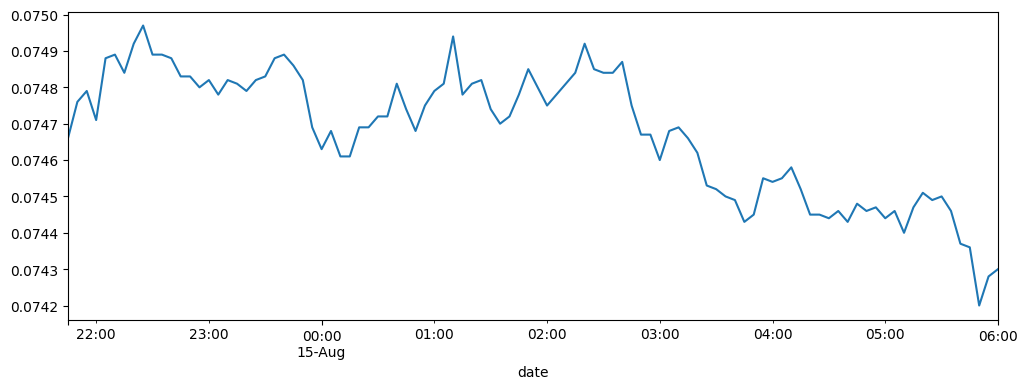

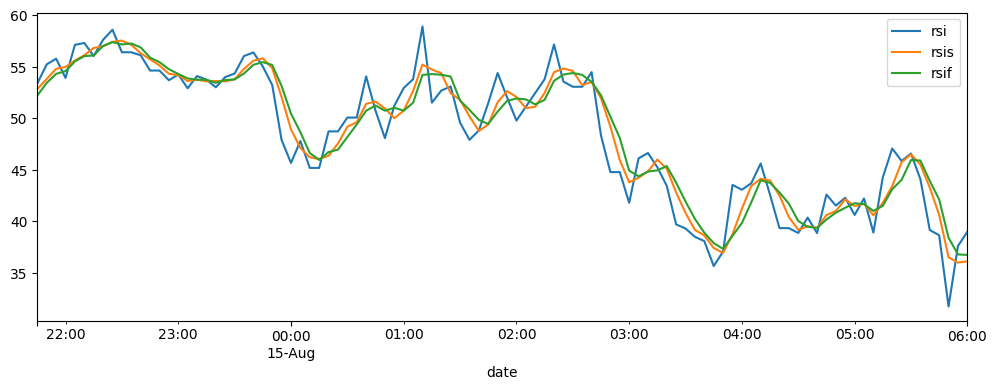

In [41]:
asset.df["close"].tail(100).plot(figsize = (12,4))
plt.show()

asset.df[["rsi", "rsis", "rsif"]].tail(100).plot(figsize = (12,4))
plt.show()

In [46]:
res = []

for r in range( 10, 50, 2 ):
    for s in range(2, 7):
        for f in range(4, 25, 2):
            if s >= f or f > r: continue
            for p in [2,3, 4]:
                for t in [ 0.0015, 0.002, 0.0025 ]:
                    asset.df["rsi"] = asset.rsi(r)
                    asset.df["rsis"] = asset.sma( s, target = "rsi" )
                    asset.df["rsif"] = asset.sma( f, target = "rsi" )

                    asset.df["buy"] = ( asset.df["rsif"] >= asset.df["rsis"]  ) & ( asset.df["rsis"].pct_change(periods = p) > 0 )
                    
                    asset = sell_column(asset, target = t)        
                    df = rule_validation(asset)
                    df = test( asset )

                    if len(df) == 0: continue

                    res.append( [ r, s, f , p, t, df["acc"].iloc[-1] , len(df), df["returns"].min(), len( df[ df["returns"] < 0 ] ) ])

res = pd.DataFrame(res)
res.columns = ["rsi", "fast", "slow", "periods", "target", "acc", "transactions", "min_return", "amount_neg_ret"]
res.sort_values(by = "acc", ascending=False, inplace = True)

In [47]:
res

,rsi,fast,slow,periods,target,acc,transactions,min_return,amount_neg_ret
7586,48,5,8,4,0.0025,1.070,62,-0.012,8
7585,48,5,8,4,0.0020,1.070,62,-0.012,8
7584,48,5,8,4,0.0015,1.070,62,-0.012,8
6132,42,4,6,2,0.0015,1.044,80,-0.030,14
6134,42,4,6,2,0.0025,1.044,80,-0.030,14
...,...,...,...,...,...,...,...,...,...
3083,28,5,8,3,0.0025,0.998,3,-0.006,2
3174,28,6,10,4,0.0015,0.998,56,-0.016,13
134,10,6,10,4,0.0025,0.985,56,-0.016,13
133,10,6,10,4,0.0020,0.985,56,-0.016,13


<AxesSubplot:>

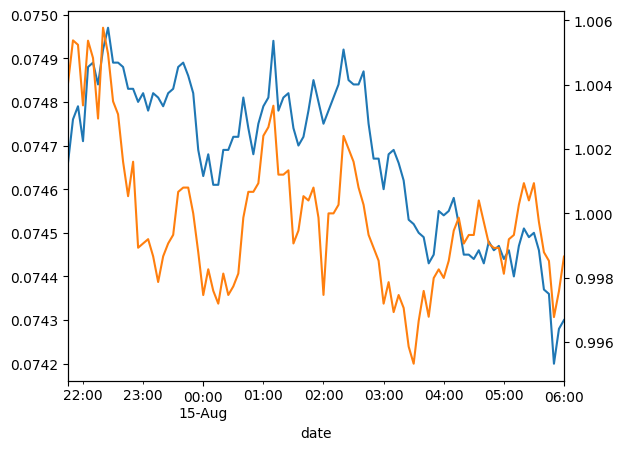

In [54]:
asset.df["momentum"] = asset.momentum(10)
asset.df["close"].tail(100).plot()
asset.df["momentum"].tail(100).plot(secondary_y = True)